In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from branca.colormap import LinearColormap
from haversine import haversine, Unit

## Pre processamento

In [2]:
def get_first_pos(file):
    df = pd.read_csv(f"./passagens/{file}")
    df = df[df['LAT'] != 0]
    df['LAT'] = df['LAT'] / 10000000
    df['LON'] = df['LON'] / 10000000
    
    lat_c = df['LAT'].mean()
    lon_c = df['LON'].mean()

    return lat_c, lon_c

In [3]:
def pre_processamento(file, lat0, lon0):
    df = pd.read_csv(f"./passagens/{file}")
    df = df[df['LAT'] != 0]
    df['LAT'] = df['LAT'] / 10000000
    df['LON'] = df['LON'] / 10000000
    df['ALT'] = df['ALT'] / 10
    
    df['ELAPSED_TIME_MIN'] = df['ELAPSED_TIME'] / 60000
    df['ELAPSED_TIME_S'] = df['ELAPSED_TIME'] / 1000
    
    df["TIMESTAMP_PC"] = (
        df["HOUR_PC"] * 3600 +
        df["MIN_PC"] * 60 +
        df["SEC_PC"] +
        df['CENT_PC'] / 100
    )
    
    df["TIMESTAMP_PC_UTC"] = df["TIMESTAMP_PC"] + 3 * 3600
    
    df["TIMESTAMP_GPS_UTC"] = (
        df["HOUR_GPS"] * 3600 +
        df["MIN_GPS"] * 60 +
        df["SEC_GPS"] +
        df["CENT_GPS"] / 100
    )
    
    if "LATENCIA" in df.columns:
        df["LATENCIA_MS"] = df["LATENCIA"] * 1000

    df['DIST_M'] = df.apply(
        lambda row: haversine(
            (lat0, lon0),
            (row['LAT'], row['LON']),
            unit=Unit.METERS
        ),
        axis=1
    )
    
    df = df.reset_index(drop=True)

    first_package = df['PACKAGE'].iloc[0]
    df['PDR'] = (df.index + 1) / (df['PACKAGE'] - first_package + 1) * 100
    df['RSSI'] = - (256 - df["RSSI"])
    
    return df

## Graficos, mapas e tabelas

In [4]:
def altura_media(file):
    df = pd.read_csv(f"./passagens/{file}")
    df = df[df['LAT'] != 0]
    min_hdop = df["HDOP"].min()
    df = df[df["HDOP"] == min_hdop]
    df["ALT"] = df["ALT"] / 10
    
    return df["ALT"].mean()

In [5]:
def max_dist(dfs):
    max_dist = 0
    for df in dfs:
        if df["DIST_M"].max() > max_dist:
            max_dist = df["DIST_M"].max()
            
    return max_dist

In [6]:
def max_dist(dfs):
    max_dist = 0
    df_i = 0
    for i, df in enumerate(dfs):
        if df["DIST_M"].max() > max_dist:
            df_i = i
            max_dist = df["DIST_M"].max()
            
    return max_dist, df_i

In [7]:
def max_rssi(dfs):
    max_rssi = -999
    df_i = 0
    for i, df in enumerate(dfs):
        if df["RSSI"].max() > max_rssi:
            df_i = i
            max_rssi = df["RSSI"].max()
            
    return max_rssi, df_i

def min_rssi(dfs):
    df_i = 0
    min_rssi = 999
    for i, df in enumerate(dfs):
        if df["RSSI"].min() < min_rssi:
            df_i = i
            min_rssi = df["RSSI"].min()
            
    return min_rssi, df_i

In [8]:
def mapa_RSSI(df, ar, sz, fr, type):
    colormapRSSI = LinearColormap(
        colors=['red', 'orange', 'green'],
        vmin=df['RSSI'].min(),
        vmax=df['RSSI'].max()
    )
    
    centro = [df['LAT'].mean(), df['LON'].mean()]
    mapa = folium.Map(location=centro, max_zoom=30, zoom_start=19, tiles=None)

    folium.TileLayer(
        'OpenStreetMap',
        name='Mapa',
        max_zoom=30
    ).add_to(mapa)

    folium.TileLayer(
        tiles='Esri.WorldImagery',
        name='Satélite',
        max_zoom=19
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)

    for _, row in df.iterrows():
        cor = colormapRSSI(row['RSSI'])

        folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            radius=5,
            color=cor,
            fill=True,
            fill_color=cor,
            fill_opacity=0.5,
            opacity=0.5,
            popup=f"RSSI: {row['RSSI']} dBm"
        ).add_to(mapa)

    # legenda
    colormapRSSI.caption = 'RSSI (dBm)'
    colormapRSSI.add_to(mapa)

    mapa.save(f"./mapas/mapaRSSI_{type}_{ar}_{sz}_{fr}.html")

In [9]:
def grafico_rssi(df, ar, sz, fr, type):
    plt.figure(figsize=(14,6))

    df = df.sort_values("DIST_M")

    rssi_smooth = df['RSSI'].rolling(window=5, center=True).mean()

    plt.plot(df['DIST_M'], df['RSSI'], alpha=0.3, label="RSSI bruto")
    plt.plot(df['DIST_M'], rssi_smooth, linewidth=2, label="Média móvel")

    plt.xlabel("Distância (m)")
    plt.ylabel("RSSI")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.savefig(f"./graficos/graficoRSSI_{type}_{ar}_{sz}_{fr}")
    plt.show()

In [10]:
def grafico_latencia(df, ar, sz, fr, type):
    plt.figure(figsize=(14,6))
    plt.plot(df['DIST_M'], df['LATENCIA_MS'])
    plt.xticks(rotation=45)
    plt.ylabel("Latência (ms)")
    plt.xlabel("Distância (m)")
    plt.savefig(f"./graficos/graficoLatencia_{type}_{ar}_{sz}_{fr}")
    plt.show()

In [11]:
def grafico_latencia_multiplot(dfs, labels):
    plt.figure(figsize=(14,6))

    for df, label in zip(dfs, labels):
        if "LATENCIA_MS" in df.columns:
            df = df.copy()

            df = df.sort_values("DIST_M")

            plt.plot(
                df["DIST_M"],
                df["LATENCIA_MS"],
                marker='o',
                linestyle='-',
                label=label
            )

    plt.xlabel("Distância (m)")
    plt.ylabel("Latência (ms)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"./graficos/graficoLatenciamult")
    plt.tight_layout()

In [12]:

def grafico_rssi_multiplot(dfs, labels, janela=5):
    plt.figure(figsize=(14,6))

    for df, label in zip(dfs, labels):
        df = df.copy()

        df = df.sort_values("DIST_M")

        # media movel
        rssi_mm = df["RSSI"].rolling(
            window=janela,
            center=True,
            min_periods = 1
        ).mean()

        # suavizacao
        plt.plot(
            df["DIST_M"],
            rssi_mm,
            linewidth=2,
            label=f"{label} (MM {janela})"
        )

    plt.xlabel("Distância (m)")
    plt.ylabel("RSSI (dBm)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("./graficos/graficoRSSImult")
    plt.show()

In [13]:
def grafico_pdr(df, ar, sz, fr, type):
    plt.figure(figsize=(14,6))
    plt.plot(df['ELAPSED_TIME_MIN'], df['PDR'])
    plt.xticks(rotation=45)
    plt.ylabel("PDR (%)")
    plt.xlabel("Tempo (m)")
    plt.savefig(f"./graficos/graficoPdr_{type}_{ar}_{sz}_{fr}")
    plt.show()

In [14]:
def grafico_pdr_multiplot(dfs, labels):
    plt.figure(figsize=(14,6))

    for df, label in zip(dfs, labels):
        if "LATENCIA_MS" not in df.columns:
            plt.plot(df['DIST_M'], df['PDR'], label=label)

    plt.xlabel("Distância (m)")
    plt.ylabel("PDR (%)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f"./graficos/graficoPDRmult")
    plt.show()

In [15]:
dfs = []

## Adquire posicao inicial do viaduto

In [16]:
lat0, lon0  = get_first_pos("./setup_gps.csv")

## Primeira configuração
Air Rate: 2.4 Kbps

Tamanho: 128 bytes

Frequência de envio: 1 Hz

In [17]:
df_24_128_ow = pre_processamento("./one_way_24_128_163534.csv", lat0, lon0)
df_24_128_pp = pre_processamento("./ping_pong_24_128_161935.csv", lat0, lon0)

idx = df_24_128_pp.index[df_24_128_pp["PACKAGE"] == 62][0]
df_24_128_pp = df_24_128_pp.iloc[idx:]

idx = df_24_128_ow.index[df_24_128_ow["PACKAGE"] == 30][0]
df_24_128_ow = df_24_128_ow.iloc[idx:]

ar = 24
sz = 128
fr = 1
dfs.append(df_24_128_pp)
dfs.append(df_24_128_ow)

In [18]:
mapa_RSSI(df_24_128_ow, ar, sz, fr, 'ow')
mapa_RSSI(df_24_128_pp, ar, sz, fr, 'pp')

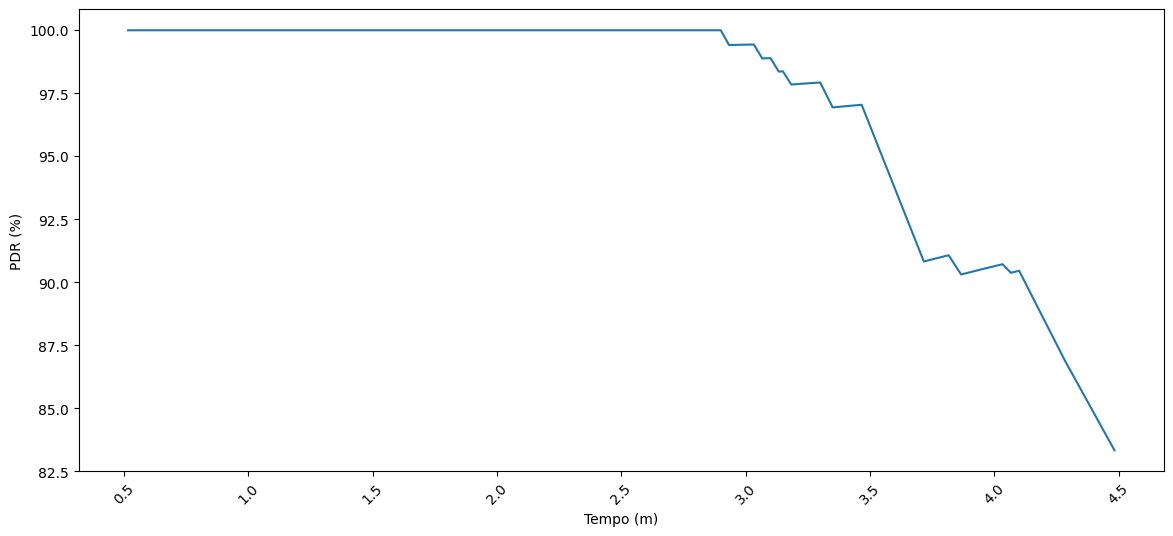

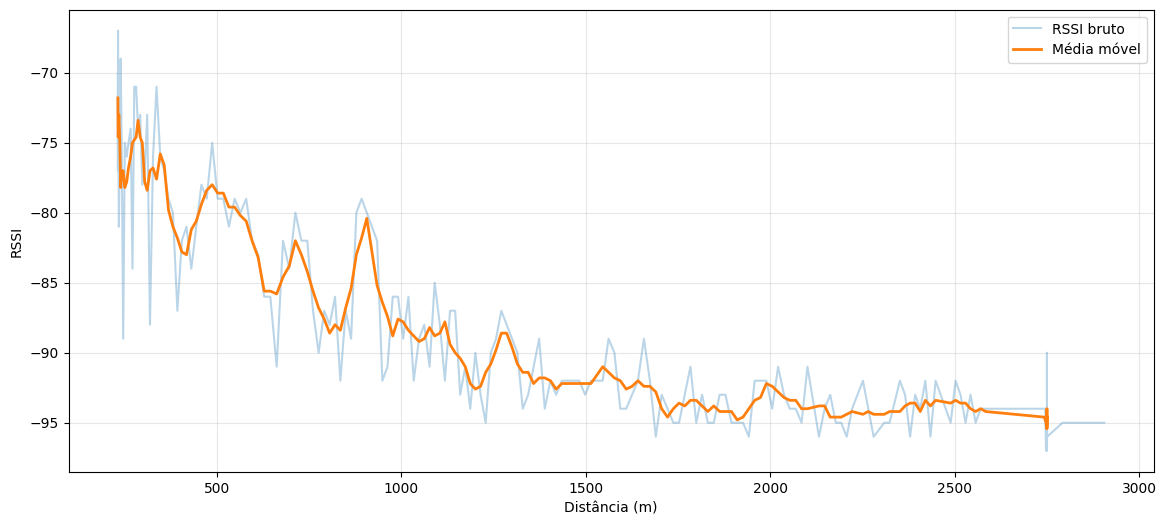

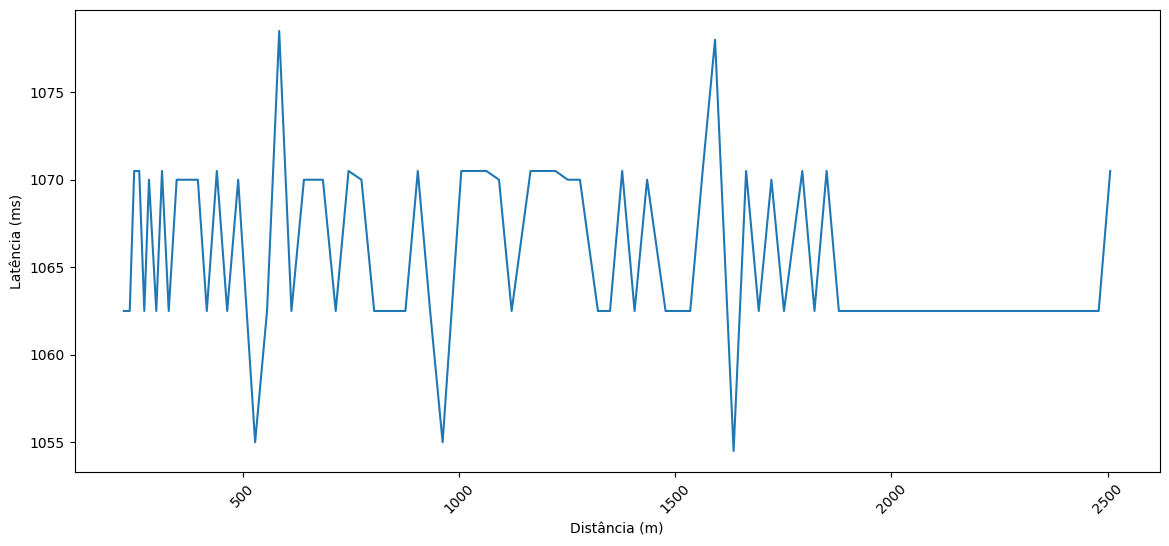

In [19]:
grafico_pdr(df_24_128_ow, ar, sz, fr, 'ow')
grafico_rssi(df_24_128_ow, ar, sz, fr, 'ow')
grafico_latencia(df_24_128_pp, ar, sz, fr, 'pp')

## Segunda configuração
Air Rate: 4.8 Kbps

Tamanho: 128 bytes

Frequência de envio: 2 Hz

In [20]:
df_48_128_ow = pre_processamento("one_way_48_128_171524.csv", lat0, lon0)
df_48_128_pp = pre_processamento("ping_pong_48_128_170028.csv", lat0, lon0)
ar = 48
sz = 128
fr = 2
dfs.append(df_48_128_pp)
dfs.append(df_48_128_ow)

In [21]:
mapa_RSSI(df_48_128_ow, ar, sz, fr, "ow")
mapa_RSSI(df_48_128_pp, ar, sz, fr, "pp")

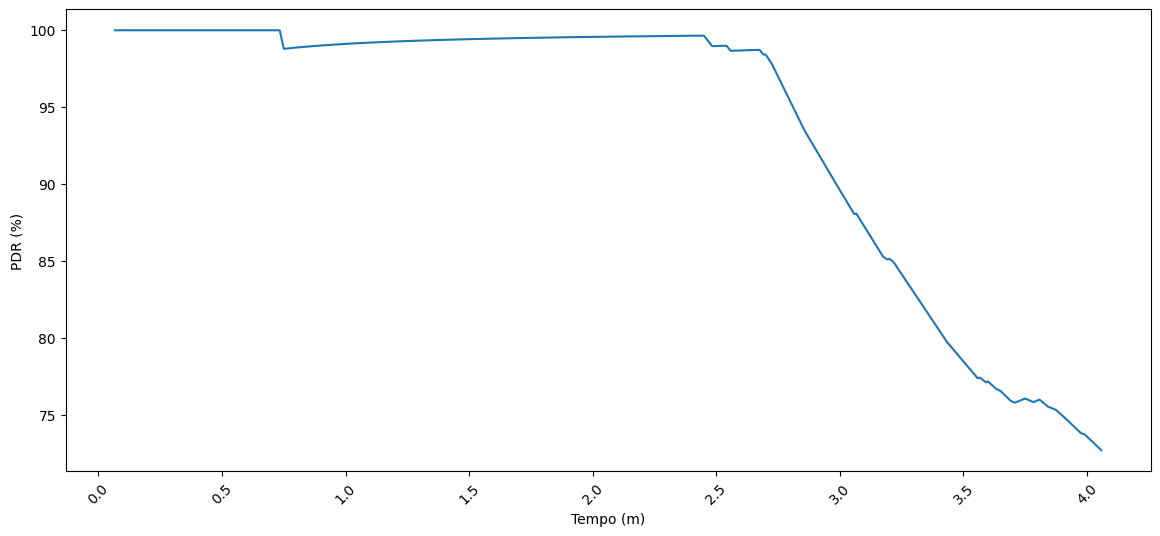

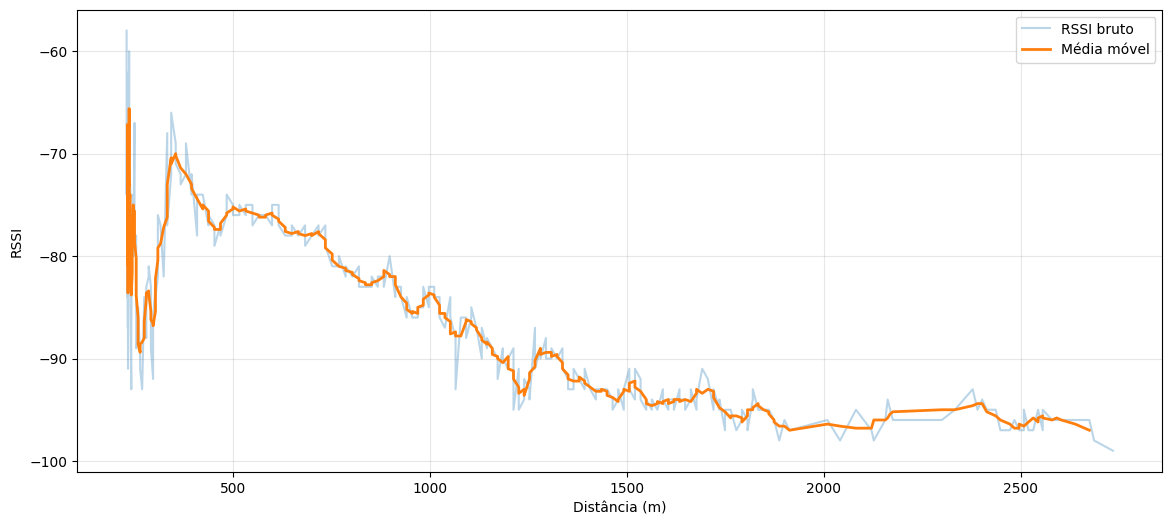

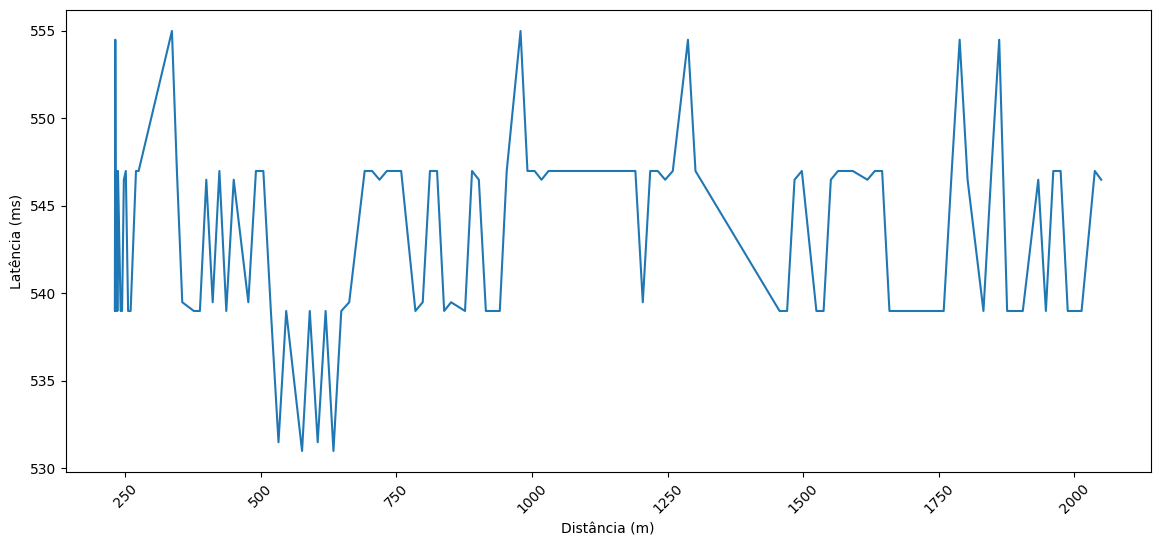

In [22]:
grafico_pdr(df_48_128_ow, ar, sz, fr, 'ow')
grafico_rssi(df_48_128_ow, ar, sz, fr, 'ow')
grafico_latencia(df_48_128_pp, ar, sz, fr, 'pp')

## Terceira configuração
Air Rate: 4.8 Kbps

Tamanho: 200 bytes

Frequência de envio: 1 Hz

In [23]:
df_48_200_ow = pre_processamento("one_way_48_200_173636.csv", lat0, lon0)
df_48_200_pp = pre_processamento("ping_pong_48_200_174953.csv", lat0, lon0)
ar = 48
sz = 200
fr = 1
dfs.append(df_48_200_pp)
dfs.append(df_48_200_ow)

In [24]:
mapa_RSSI(df_48_200_ow, ar, sz, fr, "ow")
mapa_RSSI(df_48_200_pp, ar, sz, fr, "pp")

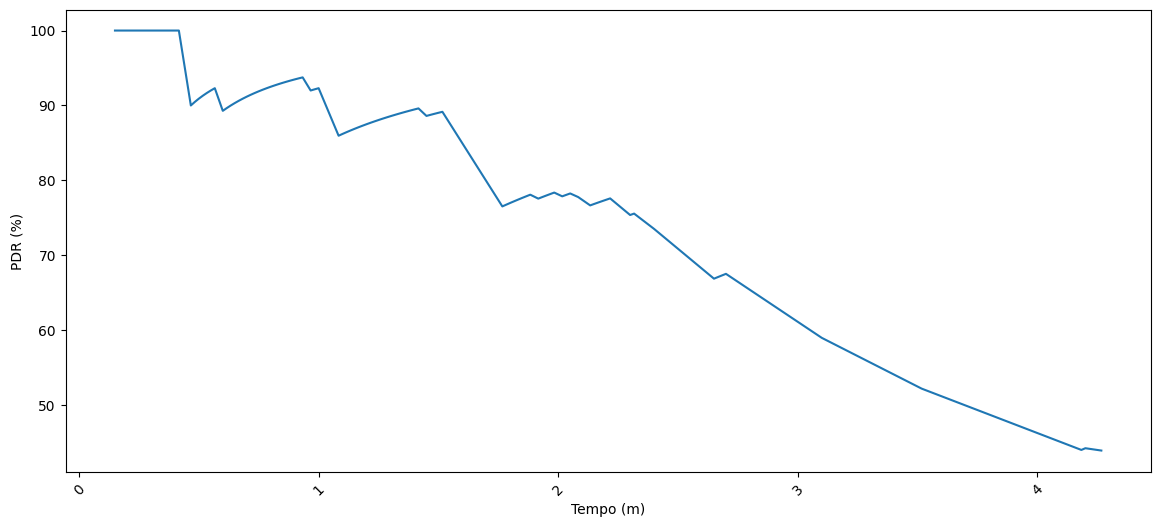

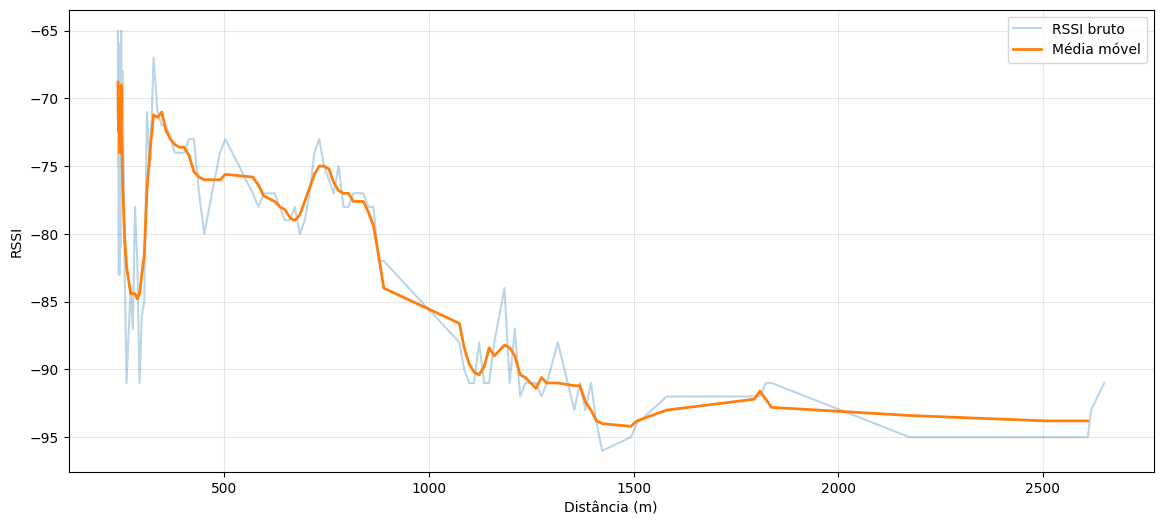

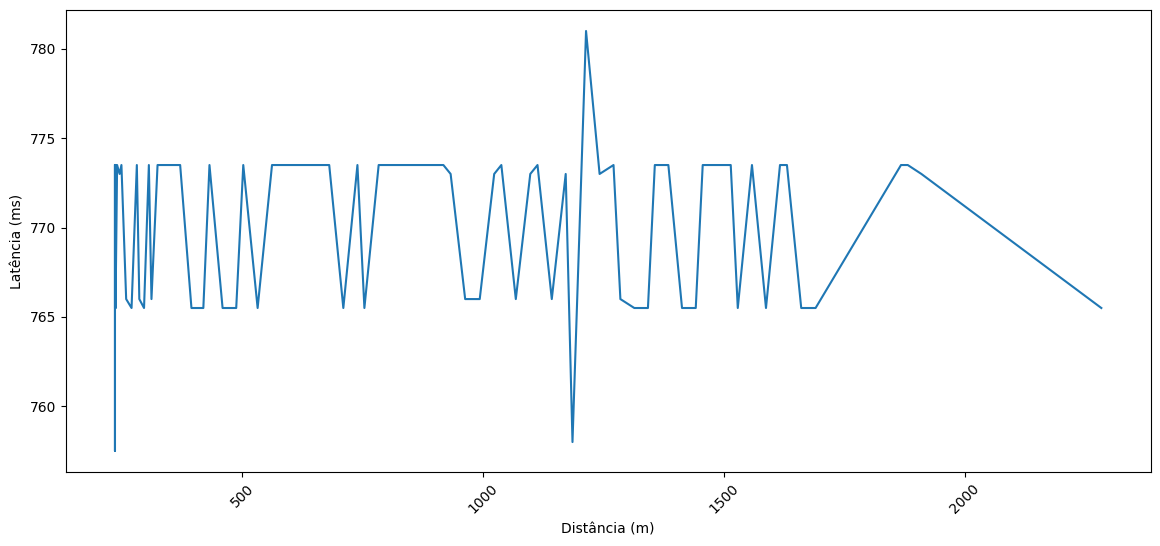

In [25]:
grafico_pdr(df_48_200_ow, ar, sz, fr, 'ow')
grafico_rssi(df_48_200_ow, ar, sz, fr, 'ow')
grafico_latencia(df_48_200_pp, ar, sz, fr, 'pp')

# Comparação

In [26]:
labels = ["2.4 Kbps, 128 bytes, Ping pong",
          "2.4 Kbps, 128 bytes, 1 Hz, One way",
          "4.8 Kbps, 128 bytes, Ping pong",
          "4.8 Kbps, 128 bytes, 2 Hz, One way",
          "4.8 Kbps, 200 bytes, Ping pong",
          "4.8 Kbps, 200 bytes, 1 Hz, One way"]

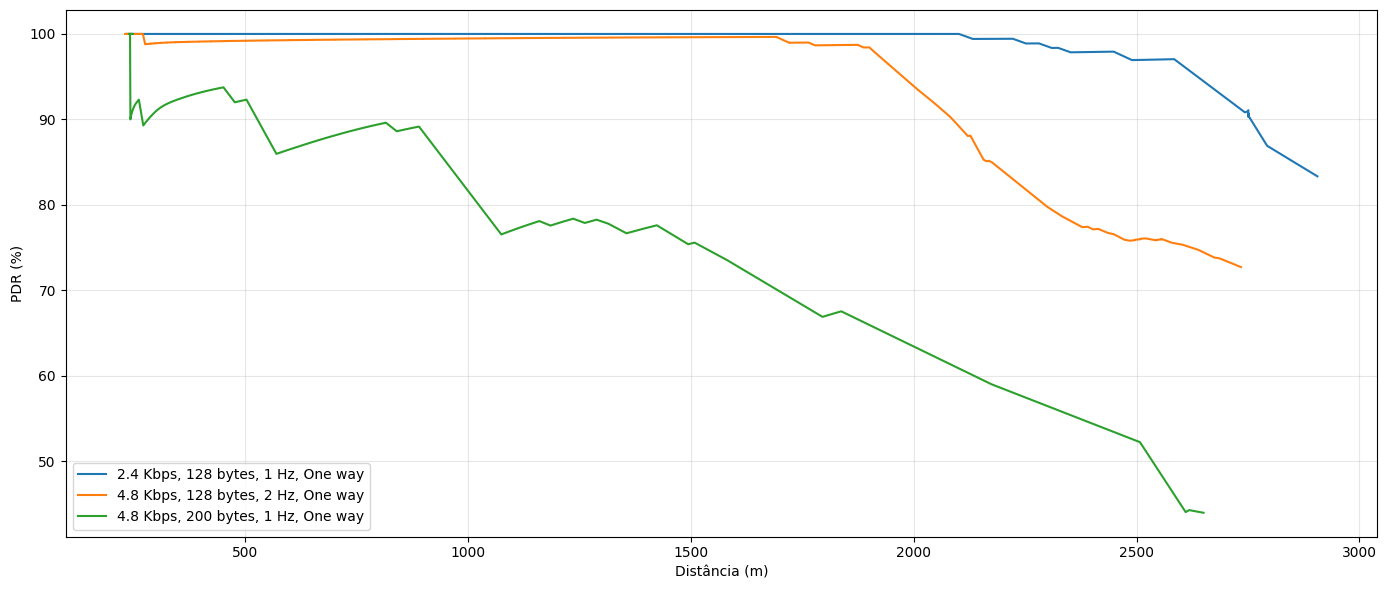

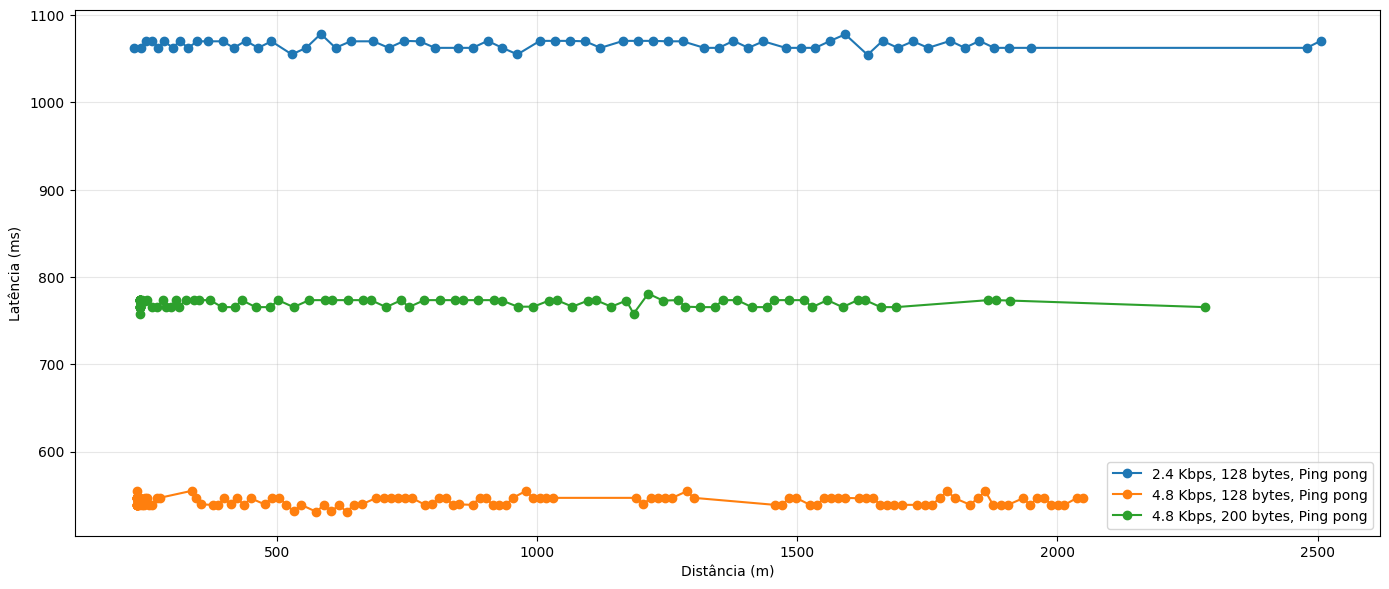

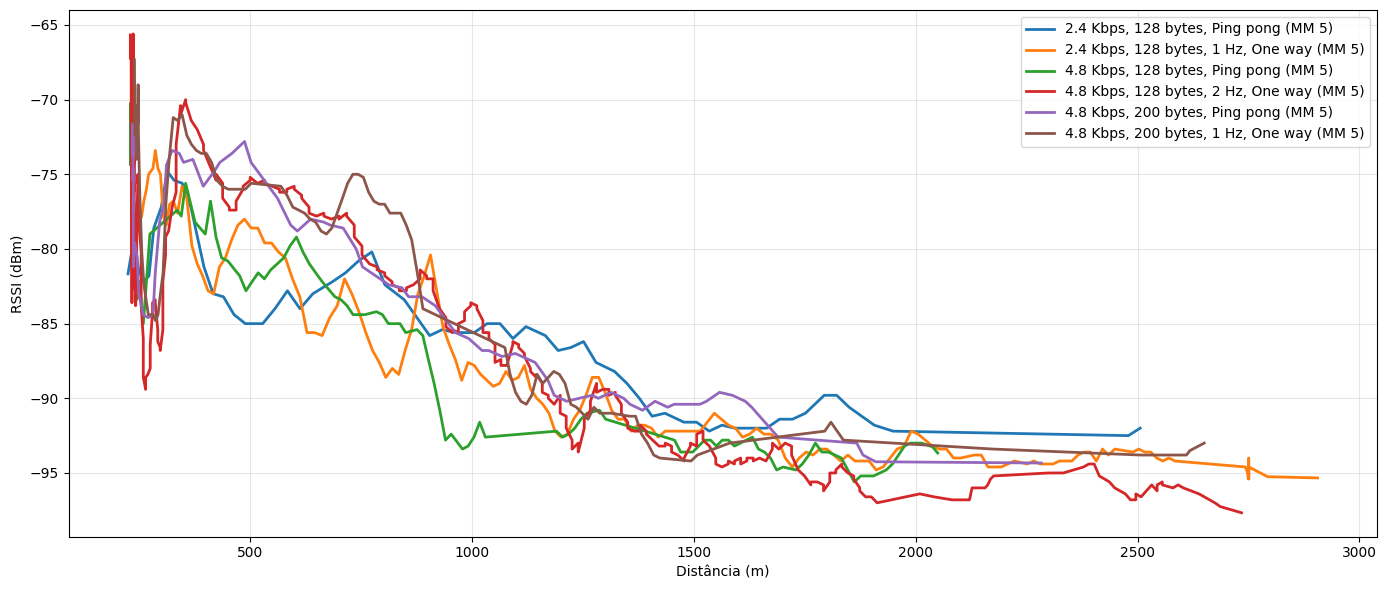

In [27]:
grafico_pdr_multiplot(dfs, labels)
grafico_latencia_multiplot(dfs, labels)
grafico_rssi_multiplot(dfs, labels)

In [28]:
max_dist_value, max_dist_df = max_dist(dfs)
print(f"Distância máxima: {max_dist_value}, Dataframe: {labels[max_dist_df]}")

max_rssi_value, max_rssi_df = max_rssi(dfs)
print(f"RSSI máximo: {max_rssi(dfs)[0]}, Dataframe: {labels[max_rssi_df]}")

min_rssi_value, min_rssi_df = min_rssi(dfs)
print(f"RSSI mínimo: {min_rssi(dfs)[0]}, Dataframe: {labels[min_rssi_df]}")

Distância máxima: 2905.59408680097, Dataframe: 2.4 Kbps, 128 bytes, 1 Hz, One way
RSSI máximo: -58, Dataframe: 4.8 Kbps, 128 bytes, 2 Hz, One way
RSSI mínimo: -99, Dataframe: 4.8 Kbps, 128 bytes, 2 Hz, One way


In [29]:
print(altura_media("setup_gps.csv"))

32.376315789473686


In [30]:
print(altura_media("one_way_48_128_171524.csv"))

6.0
